<a href="https://colab.research.google.com/github/danielahernandz/Series-de-tiempo-avanzado/blob/main/COVID_19_Colombia_caso_estudio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Competición de Kaggle
COVID19 Global Forecasting (week4) Forecast daily COVID-19 spread in regions around world.

Pronóstico global de COVID19 (semana 4) Pronostique la propagación diaria de COVID-19 en regiones de todo el mundo.
2610

In [1]:
!pip install pycountry

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 67.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pycountry: filename=pycountry-22.3.5-py2.py3-none-any.whl size=10681832 sha256=9d127fb745aa05370ba8c881a12c166d36a9ee43bc36a5c89e20b72e4fc8f51c
  Stored in directory: /root/.cache/pip/wheels/03/57/cc/290c5252ec97a6d78d36479a3c5e5ecc76318afcb241ad9dbe
Successfully built pycountry


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from prophet import Prophet
import pycountry

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0
...,...,...,...,...,...,...
28791,35656,NaN,Zimbabwe,2020-04-18,25.0,3.0
28792,35657,NaN,Zimbabwe,2020-04-19,25.0,3.0
28793,35658,NaN,Zimbabwe,2020-04-20,25.0,3.0
28794,35659,NaN,Zimbabwe,2020-04-21,28.0,3.0


Observamos que el conjunto de datos de entrenamiento llega hasta el 22-04-2020. Veamos una muestra aleatoria dentro del conjunto de entrenamiento.

In [4]:
train.sample(15) #Diferentes paises que hay

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
7673,9500,Tibet,China,2020-02-28,1.0,0.0
16021,19850,NaN,Moldova,2020-02-04,0.0,0.0
24582,30457,New Hampshire,US,2020-02-09,0.0,0.0
15239,18870,NaN,Madagascar,2020-03-21,3.0,0.0
16876,20903,"Bonaire, Sint Eustatius and Saba",Netherlands,2020-03-02,0.0,0.0
4085,5054,Northwest Territories,Canada,2020-02-28,0.0,0.0
5912,7321,Heilongjiang,China,2020-02-15,425.0,11.0
25658,31775,Rhode Island,US,2020-04-13,2665.0,63.0
8240,10199,NaN,Congo (Kinshasa),2020-03-14,2.0,0.0
24146,29911,Mississippi,US,2020-03-04,0.0,0.0


Arreglar dataframe

In [5]:
train.isnull().sum()

Id                    0
Province_State    16560
Country_Region        0
Date                  0
ConfirmedCases        0
Fatalities            0
dtype: int64

In [6]:
len(train)

28796

In [7]:
train = train.drop(['Province_State'], axis=1)
del train['Id']
train

,Country_Region,Date,ConfirmedCases,Fatalities
0,Afghanistan,2020-01-22,0.0,0.0
1,Afghanistan,2020-01-23,0.0,0.0
2,Afghanistan,2020-01-24,0.0,0.0
3,Afghanistan,2020-01-25,0.0,0.0
4,Afghanistan,2020-01-26,0.0,0.0
...,...,...,...,...
28791,Zimbabwe,2020-04-18,25.0,3.0
28792,Zimbabwe,2020-04-19,25.0,3.0
28793,Zimbabwe,2020-04-20,25.0,3.0
28794,Zimbabwe,2020-04-21,28.0,3.0


In [26]:
train['Country_Region'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Brunei', 'Bulgaria', 'Burkina Faso', 'Burma', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark',
       'Diamond Princess', 'Djibouti', 'Dominica', 'Dominican Republic',
       'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea',
       'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France',
       'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece',
       'Grenada', 'Guatemala', 'Guinea', 'Guine

##Usando Auto-ARIMA con los datos de Colombia

In [27]:
df_comp=train.copy()

Convirtiendo en fecha e indice

In [28]:
df_comp.Date = pd.to_datetime(df_comp.Date, dayfirst= True)
df_comp.set_index('Date', inplace= True)
df_comp

,Country_Region,ConfirmedCases,Fatalities
Date,,,
2020-01-22,Afghanistan,0.0,0.0
2020-01-23,Afghanistan,0.0,0.0
2020-01-24,Afghanistan,0.0,0.0
2020-01-25,Afghanistan,0.0,0.0
2020-01-26,Afghanistan,0.0,0.0
...,...,...,...
2020-04-18,Zimbabwe,25.0,3.0
2020-04-19,Zimbabwe,25.0,3.0
2020-04-20,Zimbabwe,25.0,3.0


Elegimos la predicción en especifico para Colombia

In [45]:
df = df_comp[df_comp['Country_Region']== 'Colombia']
df

,Country_Region,ConfirmedCases,Fatalities
Date,,,
2020-01-22,Colombia,0.0,0.0
2020-01-23,Colombia,0.0,0.0
2020-01-24,Colombia,0.0,0.0
2020-01-25,Colombia,0.0,0.0
2020-01-26,Colombia,0.0,0.0
...,...,...,...
2020-04-18,Colombia,3439.0,153.0
2020-04-19,Colombia,3792.0,179.0
2020-04-20,Colombia,3977.0,189.0


In [47]:
print(df.describe())
print('Total de Casos confirmados ' , df.ConfirmedCases.sum())
print('Total de muertes ' ,df.Fatalities.sum())

       ConfirmedCases  Fatalities
count       92.000000   92.000000
mean       689.467391   24.934783
std       1200.215891   52.366587
min          0.000000    0.000000
25%          0.000000    0.000000
50%          1.000000    0.000000
75%        825.000000   13.000000
max       4356.000000  206.000000
Total de Casos confirmados  63431.0
Total de muertes  2294.0


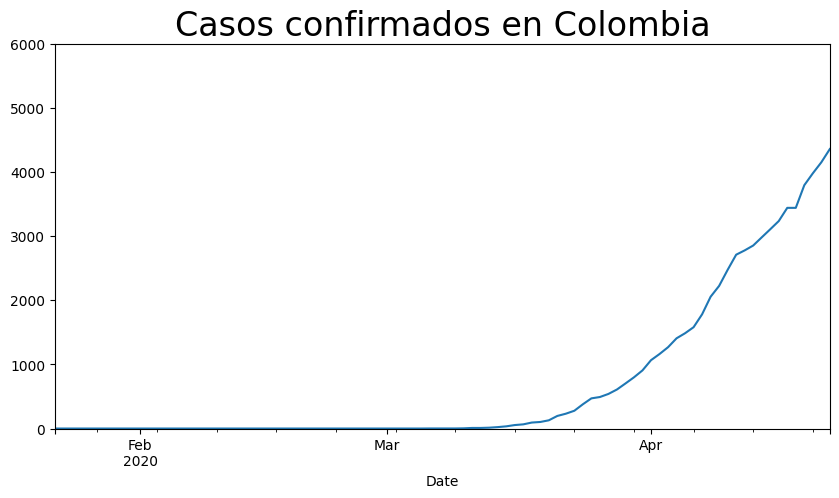

In [43]:
df.ConfirmedCases.plot(figsize= (10,5))
plt.title('Casos confirmados en Colombia', size =24)
plt.ylim(0,6000)
plt.show()

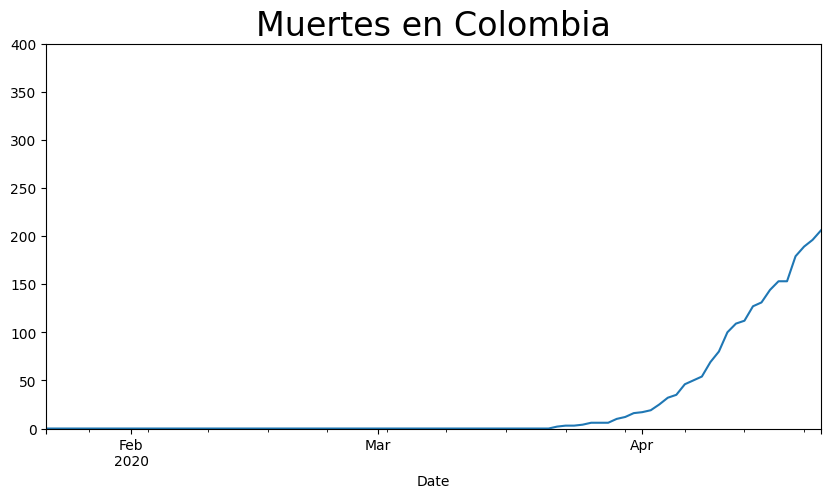

In [69]:
df.Fatalities.plot(figsize= (10,5))
plt.title('Muertes en Colombia', size =24)
plt.ylim(0,400)
plt.show()

In [48]:
!pip install pmdarima
from pmdarima.arima import auto_arima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 37.3 MB/s eta 0:00:00


#Predicción para Casos confirmados

In [70]:
#Modelo elegido más sencillo
model_auto = auto_arima(df.ConfirmedCases, m=5, start_p=2, start_P=1, max_order=5, max_p=5, max_q=5, max_d=2,
                        start_Q=1, max_P=4, max_Q=2, max_D=1,
                        maxiter=50, alpha=0.05, information_criterion='aic')

In [75]:
model_auto1 = auto_arima(df.ConfirmedCases, m=1, max_order=None, max_p=5, max_q=5, max_d=2,
                        max_P=4, max_Q=2, max_D=1,
                        maxiter=50, alpha=0.05, information_criterion='aic')

In [76]:
model_auto1

ARIMA(order=(0, 2, 1), scoring_args={}, suppress_warnings=True)

In [53]:
# model_auto = auto_arima(df.ConfirmedCases, m=5, max_order=None, max_p=5, max_q=5, max_d=2, max_P=4, max_Q=2, max_D=1,
                        # maxiter=50, alpha=0.05, information_criterion='aic')

In [77]:
model_auto1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   92
Model:               SARIMAX(0, 2, 1)   Log Likelihood                -468.014
Date:                Wed, 21 Jun 2023   AIC                            942.027
Time:                        16:56:33   BIC                            949.527
Sample:                    01-22-2020   HQIC                           945.051
                         - 04-22-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.1725      1.094      1.985      0.047       0.027       4.317
ma.L1         -0.7858      0.044    -17.668      0.000      -0.873      -0.699
sigma2      1904.1535    158.654     12.002      0.000    1593.198    2215.109
===================================================================================
Ljung-Box (L1) (Q):                   0.38   Jarque-Bera (JB):               394.03
Prob(Q):                              0.54   Prob(JB):                         0.00
Heteroskedasticity (H):              70.67   Skew:                             1.23
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [58]:
model_auto

ARIMA(order=(0, 2, 1), scoring_args={}, suppress_warnings=True)

In [72]:
model_auto.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1346: RuntimeWarning: divide by zero encountered in true_divide
  test_statistic = numer_squared_sum / denom_squared_sum


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   92
Model:             SARIMAX(1, 2, 2)x(2, 0, [], 5)   Log Likelihood                -460.711
Date:                            Wed, 21 Jun 2023   AIC                            933.423
Time:                                    16:53:43   BIC                            948.422
Sample:                                01-22-2020   HQIC                           939.471
                                     - 04-22-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9510      0.049     19.481      0.000       0.855       1.047
ma.L1         -1.7534      0.052    -33.751      0.000      -1.855      -1.652
ma.L2          0.8139      0.074     10.955      0.000       0.668       0.960
ar.S.L5       -0.7399      0.188     -3.942      0.000      -1.108      -0.372
ar.S.L10      -0.5077      0.203     -2.506      0.012      -0.905      -0.111
sigma2      1538.0476    170.168      9.038      0.000    1204.524    1871.572
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):               462.42
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):                inf   Skew:                             0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [60]:
df.tail()

,Country_Region,ConfirmedCases,Fatalities
Date,,,
2020-04-18,Colombia,3439.0,153.0
2020-04-19,Colombia,3792.0,179.0
2020-04-20,Colombia,3977.0,189.0
2020-04-21,Colombia,4149.0,196.0
2020-04-22,Colombia,4356.0,206.0


Creando indice del futuro

In [61]:
date= pd.to_datetime('04-23-2020')

In [62]:
#pd.to_timedelta crea un arreglo de fechas apartir de la primera creada
i_date = date + pd.to_timedelta(np.arange(20), 'D')
i_date #columna de fechas del futuro

DatetimeIndex(['2020-04-23', '2020-04-24', '2020-04-25', '2020-04-26',
               '2020-04-27', '2020-04-28', '2020-04-29', '2020-04-30',
               '2020-05-01', '2020-05-02', '2020-05-03', '2020-05-04',
               '2020-05-05', '2020-05-06', '2020-05-07', '2020-05-08',
               '2020-05-09', '2020-05-10', '2020-05-11', '2020-05-12'],
              dtype='datetime64[ns]', freq=None)

In [78]:
predictions = model_auto1.predict(len(i_date))

##Valores de predicción

In [79]:
df_test = pd.Series(predictions, index=i_date)
df_test.head()

2020-04-23    4545.733662
2020-04-24    4737.639785
2020-04-25    4931.718369
2020-04-26    5127.969413
2020-04-27    5326.392917
dtype: float64

In [80]:
df_auto_pred = pd.DataFrame({'Predictions': predictions},
                       index = i_date)

In [81]:
df_auto_pred.head()

,Predictions
2020-04-23,4545.733662
2020-04-24,4737.639785
2020-04-25,4931.718369
2020-04-26,5127.969413
2020-04-27,5326.392917


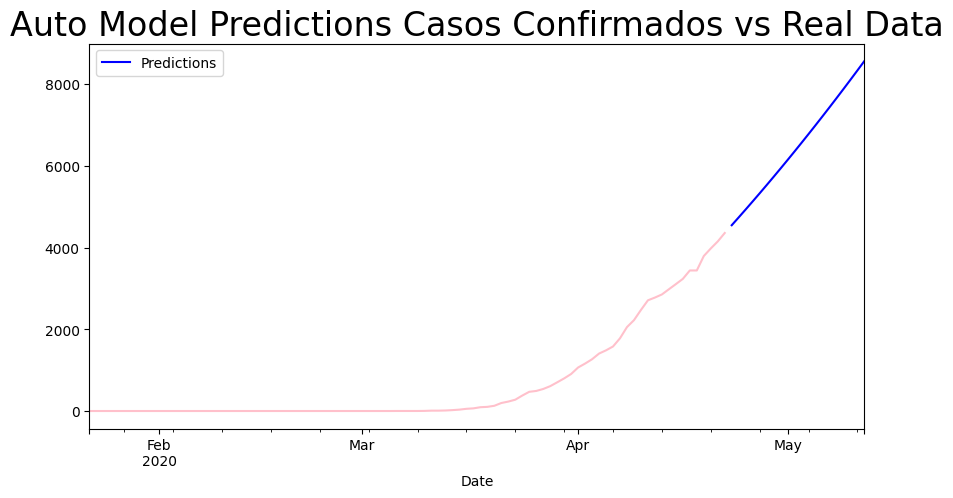

In [94]:
df_auto_pred.plot(figsize=(10,5), color = 'blue')
df.ConfirmedCases.plot(color ='pink')
plt.title('Auto Model Predictions Casos Confirmados vs Real Data', size= 24)
plt.show()

##Usando Prophet

In [85]:
df_Col = train[train['Country_Region'] == 'Colombia']
print(len(df_Col))
print(df_Col)

92
     Country_Region        Date  ConfirmedCases  Fatalities
8004       Colombia  2020-01-22             0.0         0.0
8005       Colombia  2020-01-23             0.0         0.0
8006       Colombia  2020-01-24             0.0         0.0
8007       Colombia  2020-01-25             0.0         0.0
8008       Colombia  2020-01-26             0.0         0.0
...             ...         ...             ...         ...
8091       Colombia  2020-04-18          3439.0       153.0
8092       Colombia  2020-04-19          3792.0       179.0
8093       Colombia  2020-04-20          3977.0       189.0
8094       Colombia  2020-04-21          4149.0       196.0
8095       Colombia  2020-04-22          4356.0       206.0

[92 rows x 4 columns]


##Agrupamiento por fecha y casos, para volver 'ds' 'y' para uso de Prophet

In [86]:
confirmed_col=df_Col.groupby('Date')['ConfirmedCases'].sum().to_frame().reset_index()

In [87]:
confirmed_col

,Date,ConfirmedCases
0,2020-01-22,0.0
1,2020-01-23,0.0
2,2020-01-24,0.0
3,2020-01-25,0.0
4,2020-01-26,0.0
...,...,...
87,2020-04-18,3439.0
88,2020-04-19,3792.0
89,2020-04-20,3977.0
90,2020-04-21,4149.0


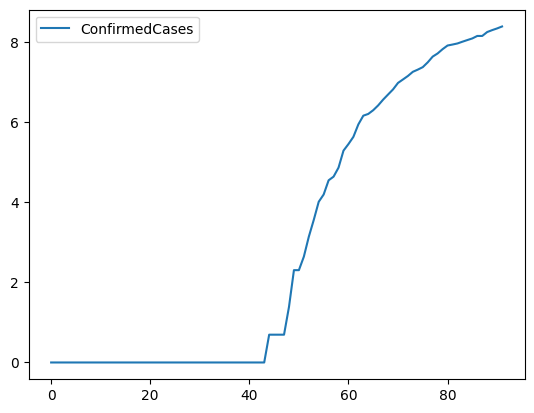

In [88]:
confirmed_col['ConfirmedCases']= np.log(1+confirmed_col['ConfirmedCases'])
confirmed_col.plot()
plt.show()

In [89]:
confirmed_col.columns= ['ds', 'y']
confirmed_col['ds'] = pd.to_datetime(confirmed_col['ds'])
confirmed_col

,ds,y
0,2020-01-22,0.000000
1,2020-01-23,0.000000
2,2020-01-24,0.000000
3,2020-01-25,0.000000
4,2020-01-26,0.000000
...,...,...
87,2020-04-18,8.143227
88,2020-04-19,8.240913
89,2020-04-20,8.288534
90,2020-04-21,8.330864


In [91]:
model_col = Prophet(interval_width=0.95)
model_col.fit(confirmed_col) #ajustamos modelo a casos confirmados
future_col= model_col.make_future_dataframe(periods= 30)
future_confirmed_col = future_col.copy()
future_col.tail()

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn5bt3kye/f4wnh54k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn5bt3kye/9tcjj1id.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63550', 'data', 'file=/tmp/tmpn5bt3kye/f4wnh54k.json', 'init=/tmp/tmpn5bt3kye/9tcjj1id.json', 'output', 'file=/tmp/tmpn5bt3kye/prophet_modelthmmgar9/prophet_model-20230621171121.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:11:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:11:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds
117,2020-05-18
118,2020-05-19
119,2020-05-20
120,2020-05-21
121,2020-05-22


Forecast

In [92]:
forecast_col = model_col.predict(future_col)
forecast_col[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2020-01-22,-0.333496,-1.698327,0.947060
1,2020-01-23,-0.302969,-1.665608,0.981277
2,2020-01-24,-0.272758,-1.526326,1.045217
3,2020-01-25,-0.270870,-1.630089,0.999218
4,2020-01-26,-0.294476,-1.637701,0.941886


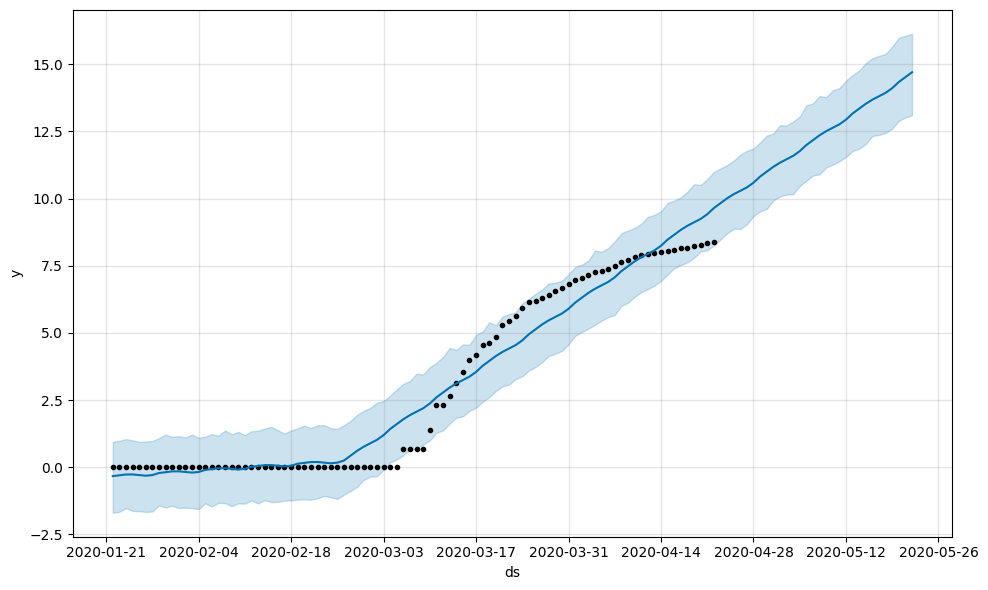

In [93]:
confirmed_forecast_plot= model_col.plot(forecast_col)

##Fatalities

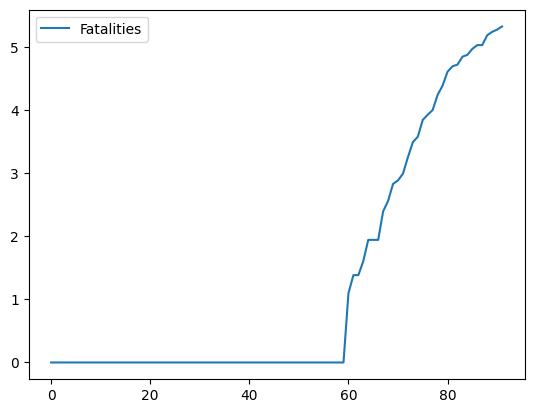

In [95]:
fatalities_col=df_Col.groupby('Date')['Fatalities'].sum().to_frame().reset_index()
fatalities_col['Fatalities']= np.log(1+fatalities_col['Fatalities'])
fatalities_col.plot()
plt.show()

In [96]:
fatalities_col.columns= ['ds', 'y']
fatalities_col['ds'] = pd.to_datetime(fatalities_col['ds']) #como fecha
fatalities_col

,ds,y
0,2020-01-22,0.000000
1,2020-01-23,0.000000
2,2020-01-24,0.000000
3,2020-01-25,0.000000
4,2020-01-26,0.000000
...,...,...
87,2020-04-18,5.036953
88,2020-04-19,5.192957
89,2020-04-20,5.247024
90,2020-04-21,5.283204


In [97]:
model_colf = Prophet(interval_width=0.95)
model_colf.fit(fatalities_col)
future_colf= model_colf.make_future_dataframe(periods= 30)
future_fatalities_col = future_colf.copy()
future_colf.tail()

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn5bt3kye/ibgpgket.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn5bt3kye/hx70zbb5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73549', 'data', 'file=/tmp/tmpn5bt3kye/ibgpgket.json', 'init=/tmp/tmpn5bt3kye/hx70zbb5.json', 'output', 'file=/tmp/tmpn5bt3kye/prophet_modelkgiqvg76/prophet_model-20230621172142.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:21:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:21:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds
117,2020-05-18
118,2020-05-19
119,2020-05-20
120,2020-05-21
121,2020-05-22


In [98]:
forecast_colf = model_colf.predict(future_colf)
forecast_colf[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2020-01-22,-0.061450,-0.514064,0.368841
1,2020-01-23,-0.016173,-0.467161,0.408157
2,2020-01-24,-0.040410,-0.482493,0.388783
3,2020-01-25,-0.065371,-0.533497,0.367292
4,2020-01-26,0.012429,-0.387576,0.477906


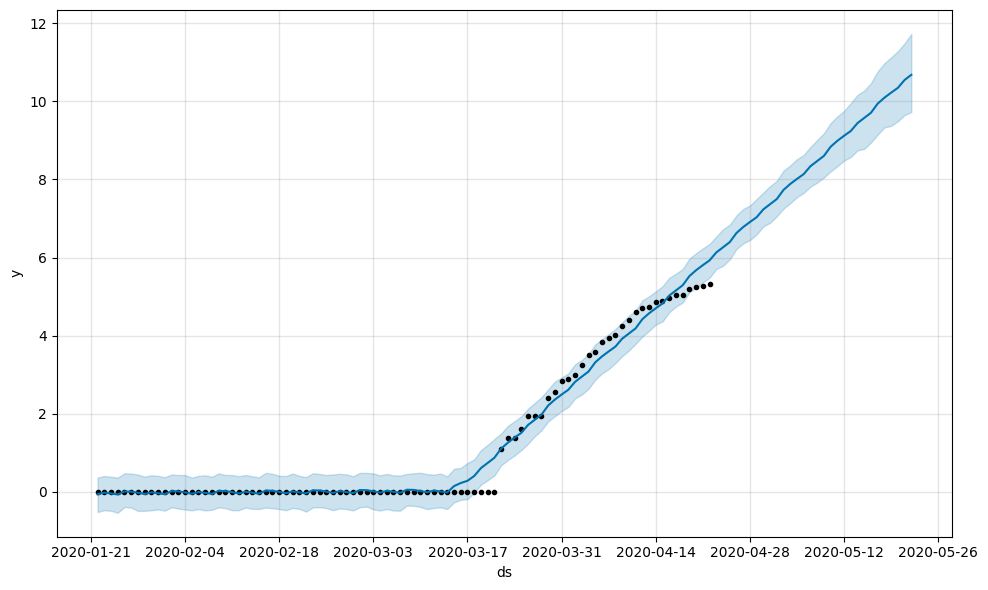

In [99]:
fatalities_col_forecast_plot= model_colf.plot(forecast_colf)